# End-to-End Image Classification Model

## For this project, we will be using a dataset containing 2,057 images of different animal classes and train a Stochastic Gradient Descent Classifier model using HOG extracted features.

## Loading the main libraries

In [11]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

from  skimage.io import imread, ImageCollection
from skimage.color import rgb2gray, rgba2rgb
from skimage.feature import hog
from skimage.transform import resize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline


import os
import re
from glob import glob
import pickle
from collections import Counter
import warnings
warnings.filterwarnings('ignore', 
                        'Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.')

## Finding all folders containing images and image paths

In [12]:
folders = os.listdir('data')
print(folders)

['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'Natural', 'PandaHead', 'PigeonHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


In [13]:
all_path = []
for folder in folders:
    all_path += glob(f"data/{folder}/*.jpg")
    

In [14]:
all_path

['data/BearHead\\bearfrontal0001.jpg',
 'data/BearHead\\bearfrontal0002.jpg',
 'data/BearHead\\bearfrontal0003.jpg',
 'data/BearHead\\bearfrontal0004.jpg',
 'data/BearHead\\bearfrontal0005.jpg',
 'data/BearHead\\bearfrontal0006.jpg',
 'data/BearHead\\bearfrontal0007.jpg',
 'data/BearHead\\bearfrontal0008.jpg',
 'data/BearHead\\bearfrontal0009.jpg',
 'data/BearHead\\bearfrontal0010.jpg',
 'data/BearHead\\bearfrontal0011.jpg',
 'data/BearHead\\bearfrontal0012.jpg',
 'data/BearHead\\bearfrontal0013.jpg',
 'data/BearHead\\bearfrontal0014.jpg',
 'data/BearHead\\bearfrontal0015.jpg',
 'data/BearHead\\bearfrontal0016.jpg',
 'data/BearHead\\bearfrontal0017.jpg',
 'data/BearHead\\bearfrontal0018.jpg',
 'data/BearHead\\bearfrontal0019.jpg',
 'data/BearHead\\bearfrontal0020.jpg',
 'data/BearHead\\bearfrontal0021.jpg',
 'data/BearHead\\bearfrontal0022.jpg',
 'data/BearHead\\bearfrontal0023.jpg',
 'data/BearHead\\bearfrontal0024.jpg',
 'data/BearHead\\bearfrontal0025.jpg',
 'data/BearHead\\bearfron

In [15]:
img_all = ImageCollection(all_path)
len(img_all)

2057

## Labeling all images

In [16]:
def extract_label(text):
    try:
        label = re.search(r'data/(.*?)Head\\', text).group(1)
    except:
        label = re.search(r'data/(.*?)\\', text).group(1)
    return label

In [17]:
labels = list(map(extract_label, img_all.files))
print(len(labels))
print(labels)

2057
['Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Bear', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat

In [18]:
pd.Series(labels).unique()

array(['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle',
       'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Natural', 'Panda',
       'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf'], dtype=object)

## Combining all images into one array

In [19]:
def buffer(io):
    return io

img_all_arrs = np.array(list(map(buffer, img_all)))
img_all_arrs.shape

(2057, 80, 80, 3)

## Creating a dataset dictionary

In [20]:
data = dict()
data['description'] = 'There are 20 classes and 2,057 total images with shape of (80,80,3) each.'
data['data'] = img_all_arrs
data['target'] = labels
data['labels'] = set(labels)
data

{'description': 'There are 20 classes and 2,057 total images with shape of (80,80,3) each.',
 'data': array([[[[196, 214, 188],
          [196, 214, 188],
          [196, 214, 188],
          ...,
          [ 81,  76,  80],
          [ 81,  76,  80],
          [ 69,  64,  68]],
 
         [[196, 214, 188],
          [196, 214, 188],
          [196, 215, 187],
          ...,
          [ 82,  77,  81],
          [ 83,  78,  82],
          [ 77,  72,  76]],
 
         [[193, 213, 185],
          [194, 214, 186],
          [194, 214, 186],
          ...,
          [ 82,  77,  81],
          [ 81,  76,  80],
          [ 78,  73,  77]],
 
         ...,
 
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [ 70,  65,  69],
          [ 65,  60,  64],
          [ 62,  57,  63]],
 
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [ 66,  61,  65],
          [ 62,  57,  61],
          [ 6

## Saving the dataset into a pickle file

In [21]:
pickle.dump(data, open('data_20.pkl', 'wb'))

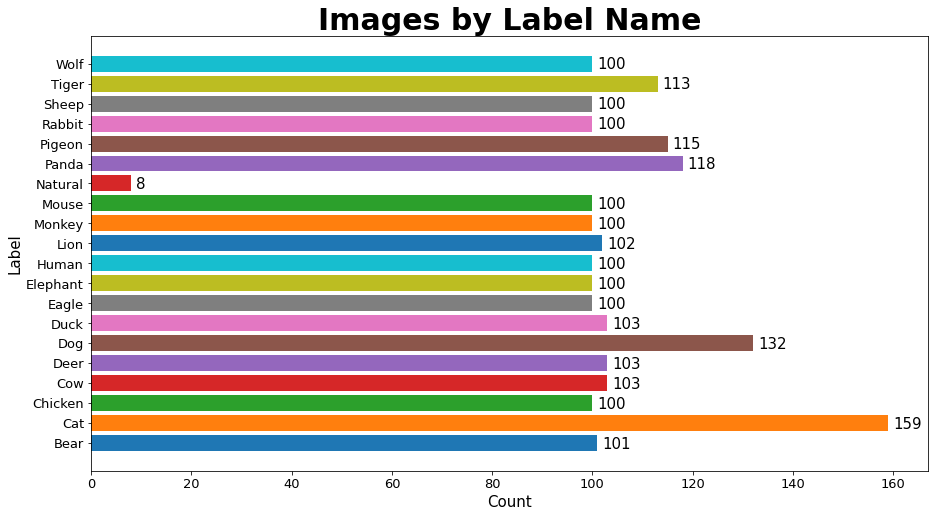

In [22]:
counter = Counter(data['target'])
x = list(counter.keys())
y = list(counter.values())
fig, ax = plt.subplots(figsize=(15,8))
ax.barh(x,y, color=sns.color_palette())
ax.tick_params(labelsize=13)
for i in range(len(x)):
    ax.text(y[i]+1, i-0.27, y[i], fontsize=15)
    
ax.set_title('Images by Label Name', fontsize=30, fontweight='semibold')
ax.set_xlabel('Count', fontsize=15)
ax.set_ylabel('Label', fontsize=15)
plt.show()

### • The fost frequent label in the dataset is "Cat", followed by "Dog" and "Panda".
### • The least frequent label in the dataset is "Natural".

# Visualizing all classes

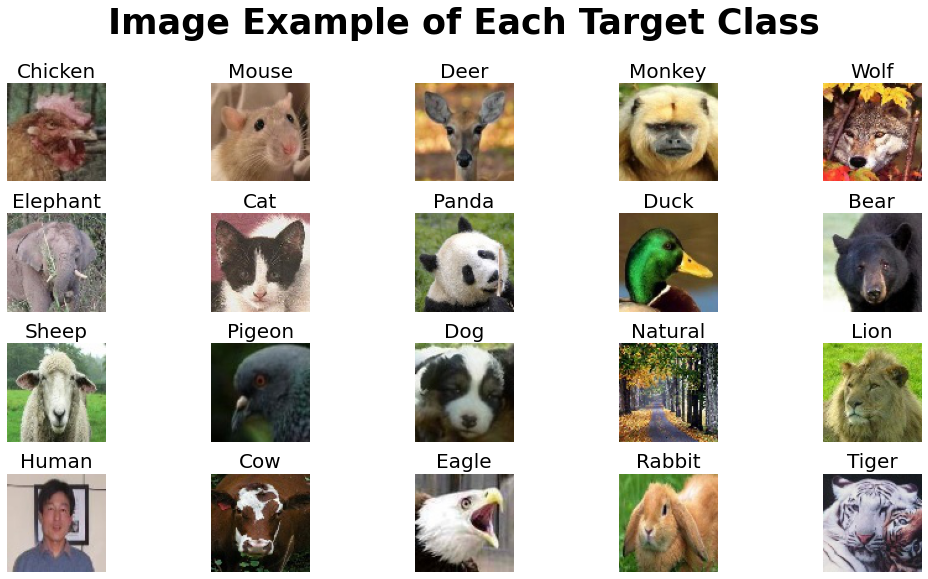

In [23]:
label_pos = [[i, data['target'].index(i)] for i in data['labels']]
index = 0
fig, ax = plt.subplots(4,5,figsize=(15,8))

for x in range(4):
    for y in range(5):
        ax[x,y].imshow(data['data'][label_pos[index][1]])
        ax[x,y].set_title(label_pos[index][0], fontsize=20)
        ax[x,y].set_axis_off()
        index += 1
fig.suptitle('Image Example of Each Target Class', fontsize=35, fontweight='semibold', y=1)
fig.tight_layout() 
plt.show()

# Building the first model

In [15]:
data = pickle.load(open('data_20.pkl', 'rb'))
data

{'description': 'There are 20 classes and 2,057 total images with shape of (80,80,3) each.',
 'data': array([[[[196, 214, 188],
          [196, 214, 188],
          [196, 214, 188],
          ...,
          [ 81,  76,  80],
          [ 81,  76,  80],
          [ 69,  64,  68]],
 
         [[196, 214, 188],
          [196, 214, 188],
          [196, 215, 187],
          ...,
          [ 82,  77,  81],
          [ 83,  78,  82],
          [ 77,  72,  76]],
 
         [[193, 213, 185],
          [194, 214, 186],
          [194, 214, 186],
          ...,
          [ 82,  77,  81],
          [ 81,  76,  80],
          [ 78,  73,  77]],
 
         ...,
 
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [ 70,  65,  69],
          [ 65,  60,  64],
          [ 62,  57,  63]],
 
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ...,
          [ 66,  61,  65],
          [ 62,  57,  61],
          [ 6

# Splitting the Data into Train/Test

In [24]:
X = data['data']
y = np.array(data['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (1645, 80, 80, 3)
y_train.shape: (1645,)
X_test.shape: (412, 80, 80, 3)
y_test.shape: (412,)


# Creating a class to transform the images into grayscale

In [25]:
class rgb2gray_transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.array([rgb2gray(x) for x in X])
        

In [26]:
rgb_2gray = rgb2gray_transform()
X_train_gray = rgb_2gray.fit_transform(X_train)
X_test_gray = rgb_2gray.fit_transform(X_test)

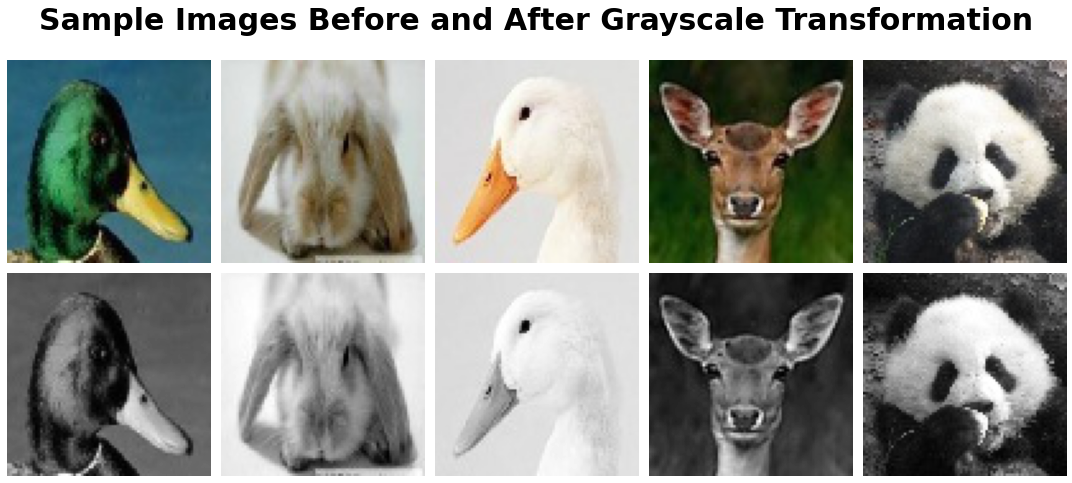

In [27]:
fig, ax = plt.subplots(2,5,figsize=(15,7))
for y in range(5):
    ax[0,y].imshow(X_train[y])
    ax[1,y].imshow(X_train_gray[y], cmap='gray')
    ax[0,y].set_axis_off()
    ax[1,y].set_axis_off()
fig.suptitle('Sample Images Before and After Grayscale Transformation', fontsize=30, fontweight='semibold')
fig.tight_layout()
plt.show()

# Creating a class to Hog-Transform the grayscale images

In [28]:
class hogtransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(10,10), cells_per_block=(3,3), visualize=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.visualize = visualize
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        def local_hog(img):
            hog_features = hog(img, orientations=self.orientations, 
                                               pixels_per_cell=self.pixels_per_cell, cells_per_block=self.cells_per_block, visualize=self.visualize)
            return hog_features
        
        features = []
        hog_images = []
        for x in X:
            results = local_hog(x)
            if self.visualize:
                features.append(results[0])
                hog_images.append(results[1])
            else:
                features.append(results)
                
        if self.visualize:
            return features, hog_images
        else:
            return features

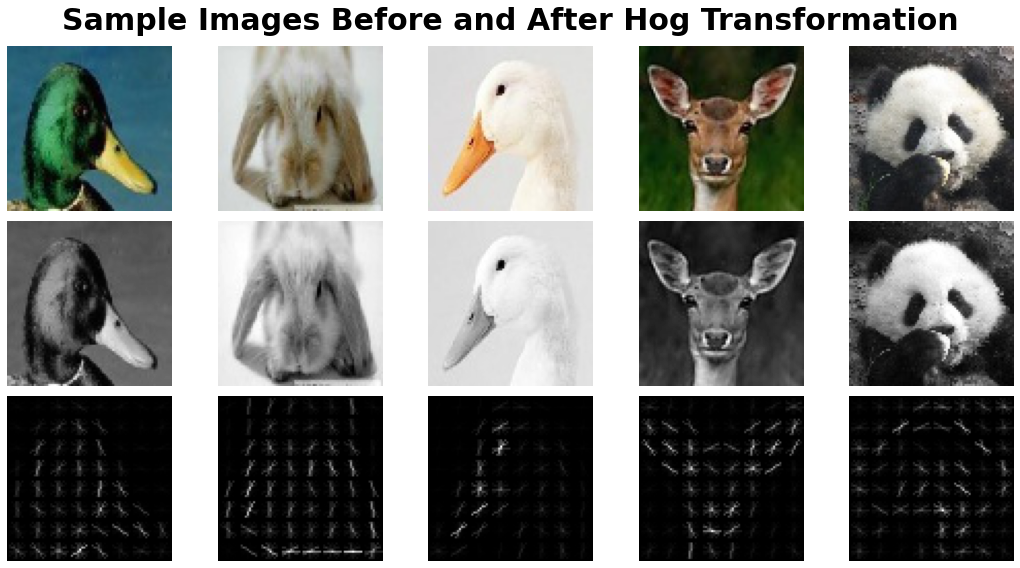

In [29]:
_, sample_hogs = hogtransformer(visualize=True).fit_transform(X_train_gray[:5])

fig, ax = plt.subplots(3,5,figsize=(15,8))
for y in range(5):
    ax[0,y].imshow(X_train[y])
    ax[1,y].imshow(X_train_gray[y], cmap='gray')
    ax[2,y].imshow(sample_hogs[y], cmap='gray')
    ax[0,y].set_axis_off()
    ax[1,y].set_axis_off()
    ax[2,y].set_axis_off()
fig.suptitle('Sample Images Before and After Hog Transformation', fontsize=30, fontweight='semibold')
fig.tight_layout()
plt.show()

# Training Machine Learning Model

In [30]:
sgd = SGDClassifier(loss='hinge', learning_rate='adaptive', early_stopping=True, eta0=0.1)

# Defining the Pipeline

In [31]:
rgb_2gray = rgb2gray_transform()
hog_transform = hogtransformer()
scaler = StandardScaler()
# Step 1: Convert into grayscale
X_train_gray = rgb_2gray.fit_transform(X_train)
X_test_gray = rgb_2gray.fit_transform(X_test)
# Step 2: Extract the HOG features
X_train_hog = hog_transform.fit_transform(X_train_gray)
X_test_hog = hog_transform.fit_transform(X_test_gray)
# Step 3: Standardize the data
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)

In [32]:
sgd.fit(X_train_scaled, y_train)

SGDClassifier(early_stopping=True, eta0=0.1, learning_rate='adaptive')

In [33]:
sgd_pred = sgd.predict(X_test_scaled)

# Model Evaluation

In [34]:
pd.DataFrame(classification_report(y_test, sgd_pred, output_dict=True)).T

precision    recall  f1-score     support
Bear           0.545455  0.600000  0.571429   20.000000
Cat            0.595238  0.781250  0.675676   32.000000
Chicken        0.571429  0.600000  0.585366   20.000000
Cow            0.523810  0.523810  0.523810   21.000000
Deer           0.684211  0.619048  0.650000   21.000000
Dog            0.764706  0.500000  0.604651   26.000000
Duck           0.736842  0.666667  0.700000   21.000000
Eagle          0.571429  0.600000  0.585366   20.000000
Elephant       0.520000  0.650000  0.577778   20.000000
Human          0.730769  0.950000  0.826087   20.000000
Lion           0.600000  0.600000  0.600000   20.000000
Monkey         0.625000  0.500000  0.555556   20.000000
Mouse          0.266667  0.200000  0.228571   20.000000
Natural        0.000000  0.000000  0.000000    1.000000
Panda          0.678571  0.791667  0.730769   24.000000
Pigeon         0.695652  0.695652  0.695652   23.000000
Rabbit         0.578947  0.550000  0.564103   20.000000
Sheep          0.428571  0.300000  0.352941   20.000000
Tiger          0.708333  0.739130  0.723404   23.000000
Wolf           0.588235  0.500000  0.540541   20.000000
accuracy       0.604369  0.604369  0.604369    0.604369
macro avg      0.570693  0.568361  0.564585  412.000000
weighted avg   0.604076  0.604369  0.598602  412.000000

In [35]:
accuracy_score(y_test, sgd_pred)

0.6043689320388349

In [36]:
cohen_kappa_score(y_test, sgd_pred)

0.5819550182703261

# Creating a data pipeline for the final classification

In [37]:
model_pipeline = Pipeline([
    ('Grayscale Transform', rgb2gray_transform()),
    ('HOG Transform', hogtransformer()),
    ('Standardization', StandardScaler()),
    ('SGD Classifier', SGDClassifier(loss='hinge', learning_rate='adaptive', early_stopping=True, eta0=0.1))
])

In [38]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Grayscale Transform', rgb2gray_transform()),
                ('HOG Transform', hogtransformer()),
                ('Standardization', StandardScaler()),
                ('SGD Classifier',
                 SGDClassifier(early_stopping=True, eta0=0.1,
                               learning_rate='adaptive'))])

In [39]:
y_pred = model_pipeline.predict(X_test)

In [40]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

precision    recall  f1-score     support
Bear           0.571429  0.600000  0.585366   20.000000
Cat            0.657895  0.781250  0.714286   32.000000
Chicken        0.608696  0.700000  0.651163   20.000000
Cow            0.785714  0.523810  0.628571   21.000000
Deer           0.772727  0.809524  0.790698   21.000000
Dog            0.782609  0.692308  0.734694   26.000000
Duck           0.750000  0.714286  0.731707   21.000000
Eagle          0.647059  0.550000  0.594595   20.000000
Elephant       0.652174  0.750000  0.697674   20.000000
Human          0.730769  0.950000  0.826087   20.000000
Lion           0.692308  0.450000  0.545455   20.000000
Monkey         0.440000  0.550000  0.488889   20.000000
Mouse          0.333333  0.250000  0.285714   20.000000
Natural        0.000000  0.000000  0.000000    1.000000
Panda          0.708333  0.708333  0.708333   24.000000
Pigeon         0.600000  0.652174  0.625000   23.000000
Rabbit         0.550000  0.550000  0.550000   20.000000
Sheep          0.600000  0.450000  0.514286   20.000000
Tiger          0.666667  0.869565  0.754717   23.000000
Wolf           0.611111  0.550000  0.578947   20.000000
accuracy       0.643204  0.643204  0.643204    0.643204
macro avg      0.608041  0.605062  0.600309  412.000000
weighted avg   0.642594  0.643204  0.636473  412.000000

# Hyperparameter Tuning with GridSearchCV

In [40]:
param_grid = {
    'HOG Transform__orientations': [7,8,9],
    'HOG Transform__pixels_per_cell': [(7,7), (8,8), (9,9)],
    'HOG Transform__cells_per_block': [(2,2), (3,3)],
    'SGD Classifier__loss': ['hinge', 'perceptron'],
    'SGD Classifier__learning_rate': ['optimal', 'adaptive'],
    'SGD Classifier__eta0': [0.001, 0.01],
    'SGD Classifier__alpha': [0.0001, 0.001]
    

}

model_grid = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2)

In [ ]:
model_grid.fit(X_train, y_train)

In [207]:
print(model_grid.best_score_)

0.7142914123888158


In [209]:
model_best = model_grid.best_estimator_
model_best

Pipeline(steps=[('Grayscale Transform', rgb2gray_transform()),
                ('HOG Transform',
                 hogtransformer(cells_per_block=(2, 2), orientations=8)),
                ('Standardization', StandardScaler()),
                ('SGD Classifier',
                 SGDClassifier(alpha=0.001, early_stopping=True, eta0=0.01,
                               loss='perceptron'))])

In [36]:
y_pred = model_best.predict(X_test)

In [41]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

precision    recall  f1-score     support
Bear           0.882353  0.750000  0.810811   20.000000
Cat            0.848485  0.875000  0.861538   32.000000
Chicken        0.869565  1.000000  0.930233   20.000000
Cow            0.826087  0.904762  0.863636   21.000000
Deer           0.833333  0.952381  0.888889   21.000000
Dog            0.529412  0.692308  0.600000   26.000000
Duck           0.842105  0.761905  0.800000   21.000000
Eagle          0.750000  0.600000  0.666667   20.000000
Elephant       0.888889  0.800000  0.842105   20.000000
Human          0.947368  0.900000  0.923077   20.000000
Lion           0.700000  0.700000  0.700000   20.000000
Monkey         0.625000  0.500000  0.555556   20.000000
Mouse          0.600000  0.600000  0.600000   20.000000
Natural        0.000000  0.000000  0.000000    1.000000
Panda          0.916667  0.916667  0.916667   24.000000
Pigeon         0.769231  0.869565  0.816327   23.000000
Rabbit         0.571429  0.400000  0.470588   20.000000
Sheep          0.681818  0.750000  0.714286   20.000000
Tiger          0.800000  0.869565  0.833333   23.000000
Wolf           0.789474  0.750000  0.769231   20.000000
accuracy       0.771845  0.771845  0.771845    0.771845
macro avg      0.733561  0.729608  0.728147  412.000000
weighted avg   0.771016  0.771845  0.767877  412.000000

### • After hyperparameter tuning, the model accuracy has significantly increased relative to our previous model.

# Saving the pipeline

In [48]:
pickle.dump(model_best, open('model_best.pkl', 'wb'))

In [41]:
pickle.load(open('model_best.pkl', 'rb'))

Pipeline(steps=[('Grayscale Transform', rgb2gray_transform()),
                ('HOG Transform',
                 hogtransformer(cells_per_block=(2, 2), orientations=8,
                                pixels_per_cell=(8, 8))),
                ('Standardization', StandardScaler()),
                ('SGD Classifier',
                 SGDClassifier(alpha=0.001, early_stopping=True, eta0=0.01,
                               loss='perceptron'))])

In [43]:
pipeline1 = make_pipeline(
    rgb2gray_transform(),
    hogtransformer(orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2))
)
                         

In [44]:
feature_vector = pipeline1.fit_transform(X_train)

In [45]:
# Standard Scaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(feature_vector)

In [46]:
model = SGDClassifier(learning_rate='optimal', loss='perceptron', alpha=0.001, early_stopping=True)

In [47]:
model.fit(scaled_X_train, y_train)

SGDClassifier(alpha=0.001, early_stopping=True, loss='perceptron')

In [48]:
# Evaluate model
feature_vector = pipeline1.fit_transform(X_test)
scaled_X_test = scaler.transform(feature_vector)
y_pred_test = model.predict(scaled_X_test)

In [49]:
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).T

precision    recall  f1-score     support
Bear           0.761905  0.800000  0.780488   20.000000
Cat            0.725000  0.906250  0.805556   32.000000
Chicken        0.760000  0.950000  0.844444   20.000000
Cow            0.750000  0.714286  0.731707   21.000000
Deer           0.913043  1.000000  0.954545   21.000000
Dog            0.640000  0.615385  0.627451   26.000000
Duck           0.750000  0.571429  0.648649   21.000000
Eagle          0.684211  0.650000  0.666667   20.000000
Elephant       0.888889  0.800000  0.842105   20.000000
Human          1.000000  0.900000  0.947368   20.000000
Lion           0.523810  0.550000  0.536585   20.000000
Monkey         0.736842  0.700000  0.717949   20.000000
Mouse          0.647059  0.550000  0.594595   20.000000
Natural        0.000000  0.000000  0.000000    1.000000
Panda          0.913043  0.875000  0.893617   24.000000
Pigeon         0.760000  0.826087  0.791667   23.000000
Rabbit         0.588235  0.500000  0.540541   20.000000
Sheep          0.583333  0.700000  0.636364   20.000000
Tiger          0.739130  0.739130  0.739130   23.000000
Wolf           0.833333  0.750000  0.789474   20.000000
accuracy       0.745146  0.745146  0.745146    0.745146
macro avg      0.709892  0.704878  0.704445  412.000000
weighted avg   0.745290  0.745146  0.742017  412.000000

# Saving the scaler and SGD model for Flask application

In [50]:
pickle.dump(model, open('model_final.pkl', 'wb'))

In [51]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
model_best

# Testing the model with a new image

In [25]:
image = imread('images/eagle.jpg')
image_scaled = resize(image, (80,80), preserve_range=True).astype(np.uint8)
image_gray = rgb2gray(image_scaled)
feature_vector, image_hog = hog(image_gray, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True)



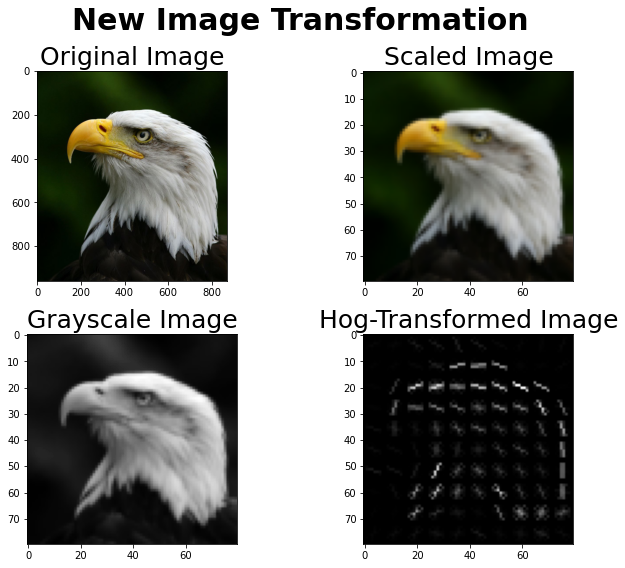

In [26]:
images = [image, image_scaled, image_gray, image_hog]
titles = ['Original Image', 'Scaled Image', 'Grayscale Image', 'Hog-Transformed Image']
cmaps = [None, None, 'gray', 'gray']
index = 0

fig, ax = plt.subplots(2,2,figsize=(10,8))
for x in range(2):
    for y in range(2):
        ax[x,y].imshow(images[index], cmap=cmaps[index])
        ax[x,y].set_title(titles[index], fontsize=25)
        index += 1
fig.suptitle('New Image Transformation', fontsize=30, fontweight='semibold')
fig.tight_layout()
plt.show()

# Load the model

In [27]:
model = pickle.load(open('model_final.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))

In [28]:
model.get_params()

{'alpha': 0.001,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'perceptron',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [29]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
results = model.predict(scalex)

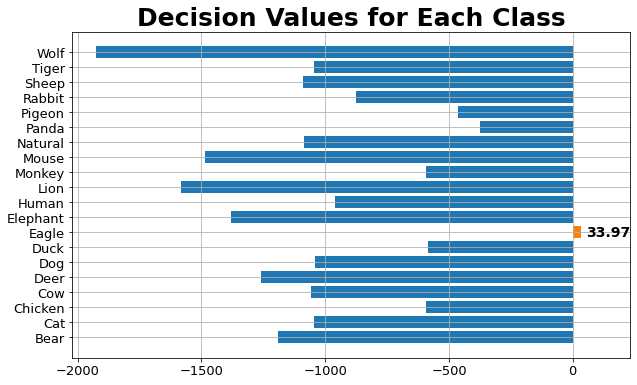

In [30]:
decision_values = model.decision_function(scalex).flatten()
classes = model.classes_
index = list(classes).index('Eagle')

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(classes, decision_values)
ax.barh(classes[index], decision_values[index])
ax.grid()
ax.text(decision_values[index]+20, index-0.3, np.round(decision_values[index], 2), fontsize=14, fontweight='semibold')
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 100)
ax.tick_params(labelsize=13)
ax.set_title('Decision Values for Each Class', fontsize=25, fontweight='semibold')
plt.show()

In [31]:
z = stats.zscore(decision_values)
z

array([-0.47644677, -0.14818746,  0.86773795, -0.17369479, -0.6311391 ,
       -0.13483903,  0.88531153,  2.27910937, -0.89553789,  0.04454711,
       -1.35169079,  0.86629171, -1.13993717, -0.23353022,  1.3624641 ,
        1.15782313,  0.23149675, -0.24260272, -0.14403785, -2.12313783])

In [32]:
prob_values = softmax(z)
prob_values

array([0.01846817, 0.02564396, 0.07082652, 0.02499812, 0.01582129,
       0.02598856, 0.0720822 , 0.2905004 , 0.01214549, 0.03109486,
       0.0076968 , 0.07072416, 0.00951204, 0.02354622, 0.11615897,
       0.09466257, 0.03748693, 0.02333356, 0.02575059, 0.00355857])

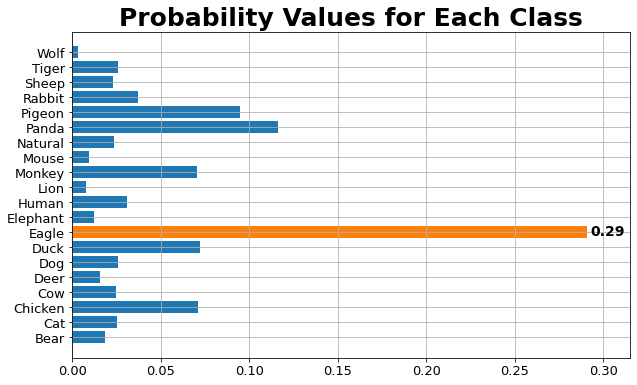

In [33]:
index = list(classes).index('Eagle')

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(classes, prob_values)
ax.barh(classes[index], prob_values[index])
ax.grid()
ax.text(prob_values[index]+0.002, index-0.2, np.round(prob_values[index], 2), fontsize=14, fontweight='semibold')
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + .01)
ax.tick_params(labelsize=13)
ax.set_title('Probability Values for Each Class', fontsize=25, fontweight='semibold')
plt.show()

In [34]:
top_5_ind = prob_values.argsort()[::-1][:5]
top_5_probs = prob_values[top_5_ind]
top_5_classes = classes[top_5_ind]


In [35]:
top_dict = {key: np.round(value, 2) for key, value in zip(top_5_classes, top_5_probs)}
top_dict

{'Eagle': 0.29, 'Panda': 0.12, 'Pigeon': 0.09, 'Duck': 0.07, 'Chicken': 0.07}

# Final model pipeline

In [47]:
def pipeline_model(path, scaler, model):
    # Reading Image
    image = imread(path)
    # Resizing Image
    image_transformed = resize(image, (80,80), preserve_range=True).astype(np.uint8)
    # Grayscale Image
    if len(image.shape) == 3:
        if image.shape[-1] == 3:
            image_gray = rgb2gray(image_transformed)
        elif image.shape[-1] == 4:
            image_gray = rgb2gray(rgba2rgb(image_transformed))
    elif len(image.shape) == 2:
        image_gray = image_transformed
        
    # Hog Features
    feature_vector = hog(image_gray, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2))
    # Scaling Image
    scalex = scaler.transform(feature_vector.reshape(1, -1))
    # Predicting Class
    result = model.predict(scalex)
    # Decision Function
    decision_values = model.decision_function(scalex).flatten()
    classes = model.classes_
    # Z-Scores
    z_scores = stats.zscore(decision_values)
    # Probabilities
    prob_values = softmax(z_scores)
    # Top 5 Results
    top_5_ind = prob_values.argsort()[::-1][:5]
    top_5_classes = classes[top_5_ind]
    top_5_probs = prob_values[top_5_ind]
    top_dict = {key: np.round(value, 2) for key, value in zip(top_5_classes, top_5_probs)}
    
    return top_dict
    
    
    